In [2]:
!pip install python-docx


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.4 MB/s eta 0:00:00


In [3]:
# ===============================
# 0. Imports
# ===============================
import pandas as pd
from docx import Document
from datetime import datetime, timedelta
import numpy as np

In [4]:
# ===============================
# 1. Constants
# ===============================
PHENO_FILE = "/content/Year wise phenology of wheat f.docx"  # Word file
WEATHER_FILE = "/content/JAU 2019-2024 merged f.xlsx"              # Excel with all years
BASE_TEMP = 5                                            # Base temp for GDD
SOWING_DAY_MONTH = "-09-30"                               # 30 Sept


In [10]:
# ===============================
# 2. Load Phenology Word Table
# ===============================
doc = Document(PHENO_FILE)
table = doc.tables[0]

# Convert table to list
data = []
for row in table.rows:
    data.append([cell.text.strip() for cell in row.cells])

# Header is second row
header = data[1]

# Remove duplicate columns
seen = {}
keep_idx = []
for idx, h in enumerate(header):
    if h not in seen:
        seen[h] = True
        keep_idx.append(idx)
header_unique = [header[i] for i in keep_idx]
data_unique = [[row[i] for i in keep_idx] for row in data[2:]]

# Create DataFrame
df_pheno = pd.DataFrame(data_unique, columns=header_unique)

# Melt to long format
df_long = df_pheno.melt(id_vars=["Growth Stage"], var_name="Season", value_name="DaysFromSowing")
df_long["DaysFromSowing"] = pd.to_numeric(df_long["DaysFromSowing"], errors="coerce")

# Extract start year from season string (e.g., 2019-20 -> 2019)
df_long["StartYear"] = df_long["Season"].str.extract(r"(20\d{2})").astype(int)

# Add sowing and stage dates (fix: use correct constant name)
df_long["SowingDate"] = pd.to_datetime(df_long["StartYear"].astype(str) + SOWING_DAY_MONTH)
df_long["StageDate"] = df_long["SowingDate"] + pd.to_timedelta(df_long["DaysFromSowing"] - 1, unit="D")

# Variety placeholder (fix: avoid NameError)
df_long["Variety"] = "Wheat"

print("Phenology data long format:")
print(df_long.head())


Phenology data long format:
                  Growth Stage   Season  DaysFromSowing  StartYear SowingDate  \
0                    Emergence  2019-20               7       2019 2019-09-30   
1  Crown Root Initiation (CRI)  2019-20              23       2019 2019-09-30   
2                    Tillering  2019-20              38       2019 2019-09-30   
3                      Booting  2019-20              61       2019 2019-09-30   
4                    Flowering  2019-20              85       2019 2019-09-30   

   StageDate Variety  
0 2019-10-06   Wheat  
1 2019-10-22   Wheat  
2 2019-11-06   Wheat  
3 2019-11-29   Wheat  
4 2019-12-23   Wheat  


In [11]:
# ===============================
# 3. Load Weather Data
# ===============================
weather = pd.read_excel(WEATHER_FILE)
weather.rename(columns={'max': 'maxt', 'min': 'mint'}, inplace=True)
weather.columns = weather.columns.str.lower()
weather['date'] = pd.to_datetime(weather['date'])

# Compute daily mean temperature and GDD
weather['tmean'] = (weather['maxt'] + weather['mint']) / 2
weather['gdd'] = (weather['tmean'] - BASE_TEMP).clip(lower=0)
weather['cumgdd'] = weather.groupby(weather['date'].dt.year)['gdd'].cumsum()

In [12]:
# ===============================
# 4. Aggregate Weather for Each Stage
# ===============================
def aggregate_weather(df_pheno_subset, weather_df):
    rows = []
    for _, r in df_pheno_subset.iterrows():
        y = r["StartYear"]
        sow = r["SowingDate"]
        stage = r["StageDate"]
        w = weather_df[(weather_df["date"] >= sow) & (weather_df["date"] <= stage)]
        if w.empty:
            print(f"⚠️ No weather data for Year {y}, Stage {r['Growth Stage']}")
            continue
        row = {
            "Year": y,
            "Stage": r["Growth Stage"],
            "DaysFromSowing": r["DaysFromSowing"],
            "CumGDD_to_stage": w["cumgdd"].iloc[-1],
            "AvgTemp_to_stage": w["tmean"].mean()
        }
        rows.append(row)
    return pd.DataFrame(rows)


In [13]:
# ===============================
# 5. Split into Training and Validation
# ===============================
train_seasons = ["2019-20", "2020-21", "2021-22", "2022-23"]
val_seasons = ["2023-24"]

df_train_pheno = df_long[df_long["Season"].isin(train_seasons)]
df_val_pheno = df_long[df_long["Season"].isin(val_seasons)]

dataset_train = aggregate_weather(df_train_pheno, weather)
dataset_val = aggregate_weather(df_val_pheno, weather)

print("Dataset train head:")
print(dataset_train.head())
print("Dataset val head:")
print(dataset_val.head())

Dataset train head:
   Year                        Stage  DaysFromSowing  CumGDD_to_stage  \
0  2019                    Emergence               7          6077.05   
1  2019  Crown Root Initiation (CRI)              23          6438.95   
2  2019                    Tillering              38          6744.70   
3  2019                      Booting              61          7170.20   
4  2019                    Flowering              85          7513.95   

   AvgTemp_to_stage  
0         25.778571  
1         27.058696  
2         26.397368  
3         25.304918  
4         23.615882  
Dataset val head:
   Year                        Stage  DaysFromSowing  CumGDD_to_stage  \
0  2023                    Emergence               8          6528.75   
1  2023  Crown Root Initiation (CRI)              25          6930.15   
2  2023                    Tillering              36          7168.05   
3  2023                      Booting              63          7696.40   
4  2023                   

In [14]:
# ===============================
# 6. ML Modeling
# ===============================
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

features = ["CumGDD_to_stage", "AvgTemp_to_stage"]
target = "DaysFromSowing"

X_train, y_train = dataset_train[features], dataset_train[target]
X_val, y_val = dataset_val[features], dataset_val[target]

# --- Linear Regression ---
lr = LinearRegression().fit(X_train, y_train)
pred_lr = lr.predict(X_val)

# --- Random Forest ---
rf = RandomForestRegressor(random_state=42, n_estimators=300)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

# --- SVM ---
svm = Pipeline([("scaler", StandardScaler()), ("svr", SVR(C=10, epsilon=1.0))])
svm.fit(X_train, y_train)
pred_svm = svm.predict(X_val)

# --- XGBoost ---
xg = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42, n_jobs=2)
xg.fit(X_train, y_train)
pred_xgb = xg.predict(X_val)

In [15]:
# ===============================
# 7. Results
# ===============================
results = pd.DataFrame({
    "Stage": dataset_val["Stage"],
    "ActualDays": dataset_val["DaysFromSowing"],
    "LR": pred_lr,
    "RF": pred_rf,
    "SVM": pred_svm,
    "XGB": pred_xgb
})
print("Prediction Results:")
print(results)

Prediction Results:
                         Stage  ActualDays          LR          RF  \
0                    Emergence           8    4.093647   20.776667   
1  Crown Root Initiation (CRI)          25   17.832543   37.270000   
2                    Tillering          36   26.776876   54.043333   
3                      Booting          63   45.558717   57.163333   
4                    Flowering          87   68.831031   84.230000   
5           Anthesis/Flowering          97   89.575890   93.846667   
6                Milking Stage         111   94.801042   96.856667   
7                  Dough Stage         123   99.679756   99.643333   
8                     Maturity         131  101.302792  114.763333   

          SVM         XGB  
0   26.618101   20.231054  
1   25.099087   34.262978  
2   28.907657   59.244873  
3   47.683739   62.008057  
4   74.297476   87.998772  
5   92.613883   95.994202  
6   97.980640   99.960152  
7  102.705332   96.313538  
8  104.256953  112.781662  

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ===============================
# 7. Results + Metrics
# ===============================
results = pd.DataFrame({
    "Stage": dataset_val["Stage"],
    "ActualDays": dataset_val["DaysFromSowing"],
    "LR": pred_lr,
    "RF": pred_rf,
    "SVM": pred_svm,
    "XGB": pred_xgb
})

print("Prediction Results:")
print(results)

# Function to calculate metrics
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

# Calculate metrics for each model
metrics_lr = regression_metrics(y_val, pred_lr)
metrics_rf = regression_metrics(y_val, pred_rf)
metrics_svm = regression_metrics(y_val, pred_svm)
metrics_xgb = regression_metrics(y_val, pred_xgb)

# Combine metrics into a DataFrame for easy comparison
metrics_df = pd.DataFrame({
    "LinearRegression": metrics_lr,
    "RandomForest": metrics_rf,
    "SVM": metrics_svm,
    "XGBoost": metrics_xgb
})

print("\nRegression Metrics for Validation Set:")
print(metrics_df)


Prediction Results:
                         Stage  ActualDays          LR          RF  \
0                    Emergence           8    4.093647   20.776667   
1  Crown Root Initiation (CRI)          25   17.832543   37.270000   
2                    Tillering          36   26.776876   54.043333   
3                      Booting          63   45.558717   57.163333   
4                    Flowering          87   68.831031   84.230000   
5           Anthesis/Flowering          97   89.575890   93.846667   
6                Milking Stage         111   94.801042   96.856667   
7                  Dough Stage         123   99.679756   99.643333   
8                     Maturity         131  101.302792  114.763333   

          SVM         XGB  
0   26.618101   20.231054  
1   25.099087   34.262978  
2   28.907657   59.244873  
3   47.683739   62.008057  
4   74.297476   87.998772  
5   92.613883   95.994202  
6   97.980640   99.960152  
7  102.705332   96.313538  
8  104.256953  112.781662  

In [17]:
# ===============================
# 8. Training Metrics
# ===============================
# Predict on training set
train_pred_lr = lr.predict(X_train)
train_pred_rf = rf.predict(X_train)
train_pred_svm = svm.predict(X_train)
train_pred_xgb = xg.predict(X_train)

# Calculate metrics for training set
metrics_lr_train = regression_metrics(y_train, train_pred_lr)
metrics_rf_train = regression_metrics(y_train, train_pred_rf)
metrics_svm_train = regression_metrics(y_train, train_pred_svm)
metrics_xgb_train = regression_metrics(y_train, train_pred_xgb)

# Combine metrics into a comparison dataframe
comparison_df = pd.DataFrame({
    "LinearRegression_Train": metrics_lr_train,
    "LinearRegression_Val": metrics_lr,
    "RandomForest_Train": metrics_rf_train,
    "RandomForest_Val": metrics_rf,
    "SVM_Train": metrics_svm_train,
    "SVM_Val": metrics_svm,
    "XGBoost_Train": metrics_xgb_train,
    "XGBoost_Val": metrics_xgb
})

print("Comparison of Training and Validation Metrics:")
print(comparison_df)


Comparison of Training and Validation Metrics:
      LinearRegression_Train  LinearRegression_Val  RandomForest_Train  \
MSE               186.232391            281.032156            3.343239   
RMSE               13.646699             16.764014            1.828453   
MAE                 9.926856             14.727523            1.222315   
R2                  0.890058              0.842058            0.998026   

      RandomForest_Val   SVM_Train     SVM_Val  XGBoost_Train  XGBoost_Val  
MSE         188.915353  162.528510  234.299183       0.000002   216.074661  
RMSE         13.744648   12.748667   15.306835       0.001453    14.699478  
MAE          12.065185    9.371799   13.141279       0.001088    11.520008  
R2            0.893828    0.904052    0.868322       1.000000     0.878564  


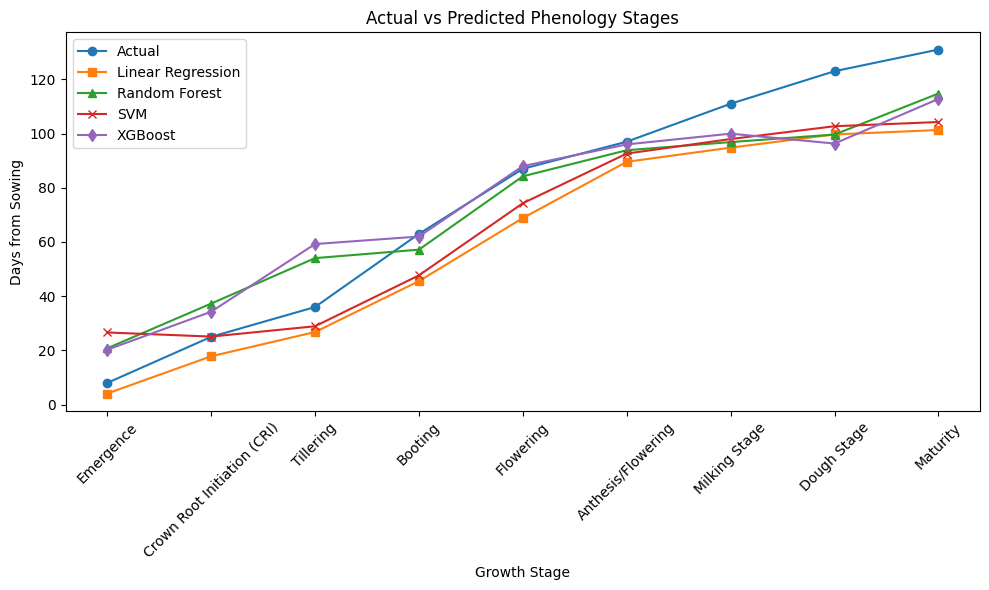

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(results["Stage"], results["ActualDays"], marker="o", label="Actual")
plt.plot(results["Stage"], results["LR"], marker="s", label="Linear Regression")
plt.plot(results["Stage"], results["RF"], marker="^", label="Random Forest")
plt.plot(results["Stage"], results["SVM"], marker="x", label="SVM")
plt.plot(results["Stage"], results["XGB"], marker="d", label="XGBoost")
plt.xlabel("Growth Stage")
plt.ylabel("Days from Sowing")
plt.title("Actual vs Predicted Phenology Stages")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=300)
plt.show()


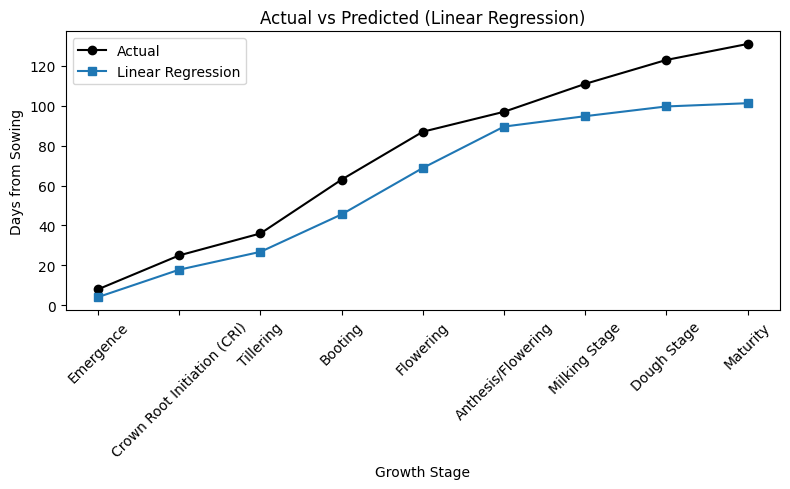

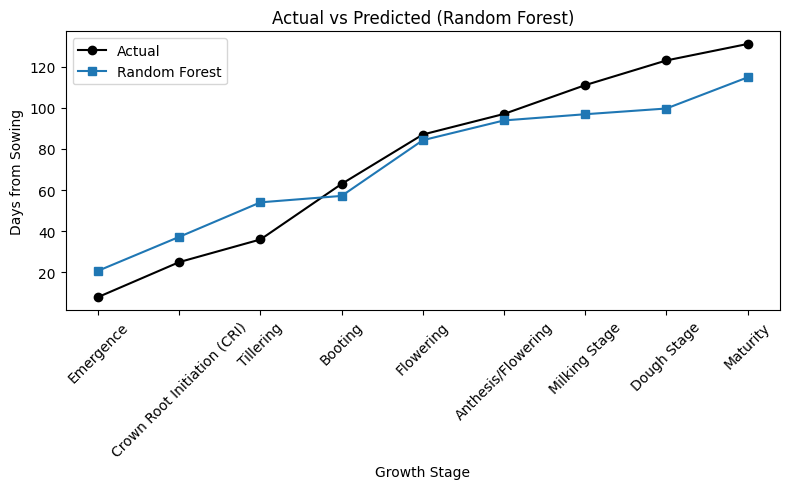

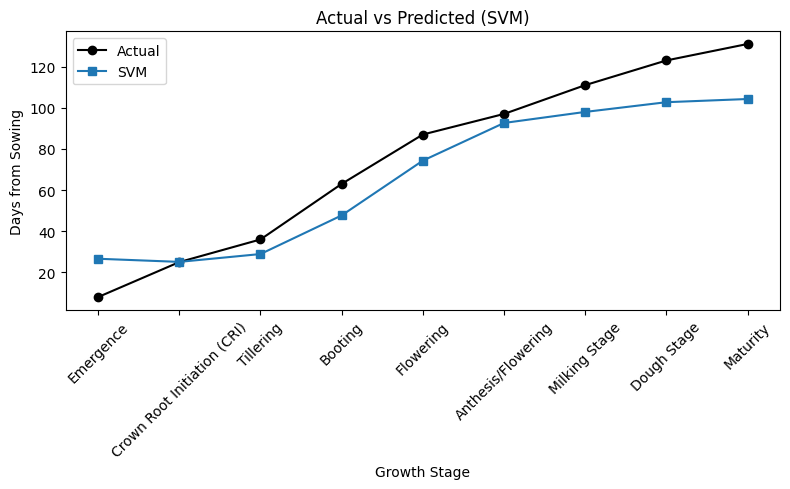

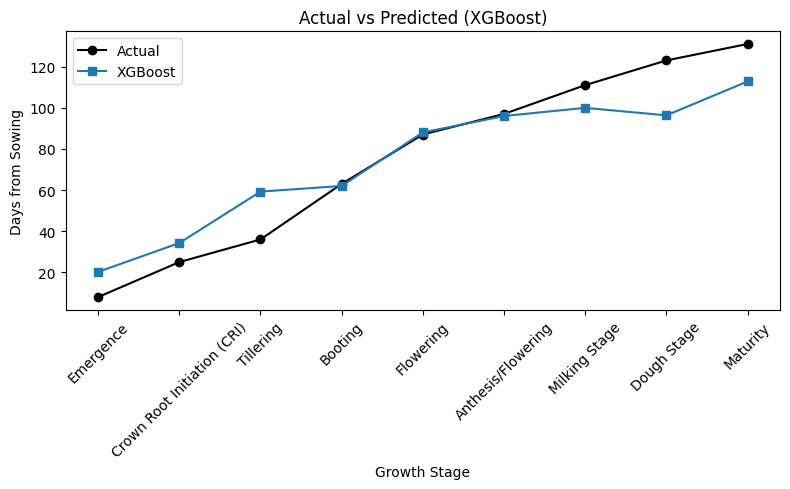

In [19]:
models = {
    "Linear Regression": "LR",
    "Random Forest": "RF",
    "SVM": "SVM",
    "XGBoost": "XGB"
}

for model_name, col in models.items():
    plt.figure(figsize=(8,5))
    plt.plot(results["Stage"], results["ActualDays"], marker="o", label="Actual", color="black")
    plt.plot(results["Stage"], results[col], marker="s", label=model_name)
    plt.xlabel("Growth Stage")
    plt.ylabel("Days from Sowing")
    plt.title(f"Actual vs Predicted ({model_name})")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"actual_vs_predicted_{col}.png", dpi=300)
    plt.show()


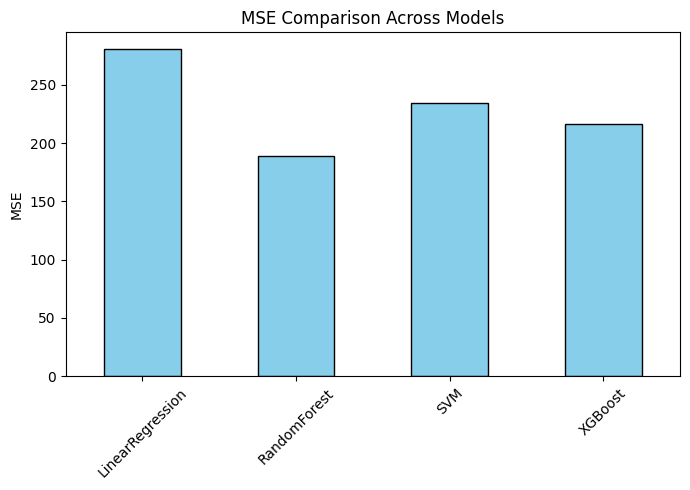

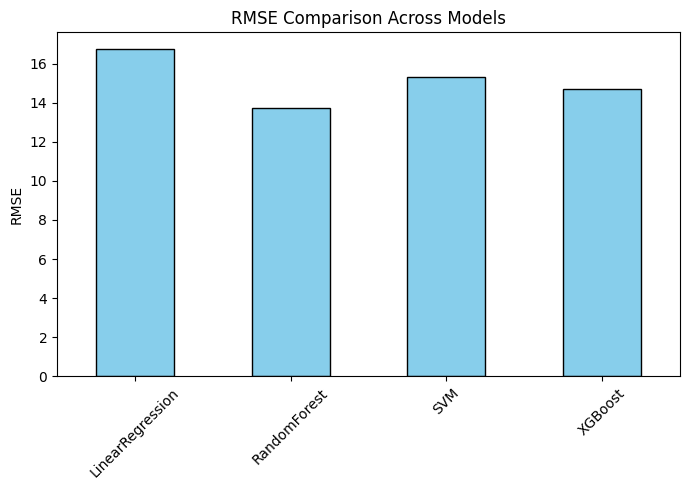

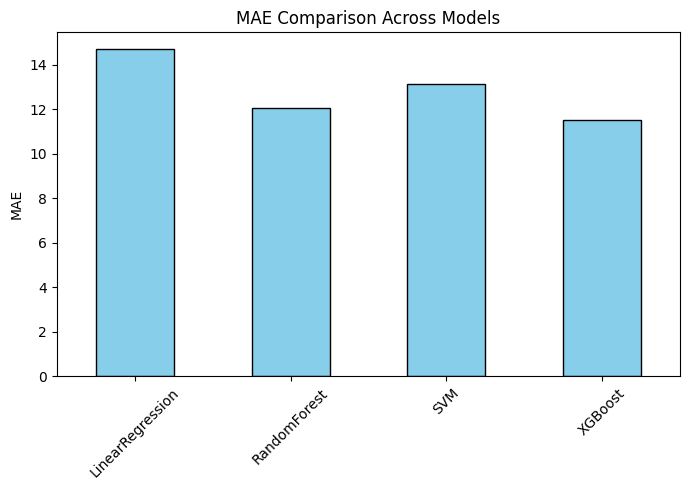

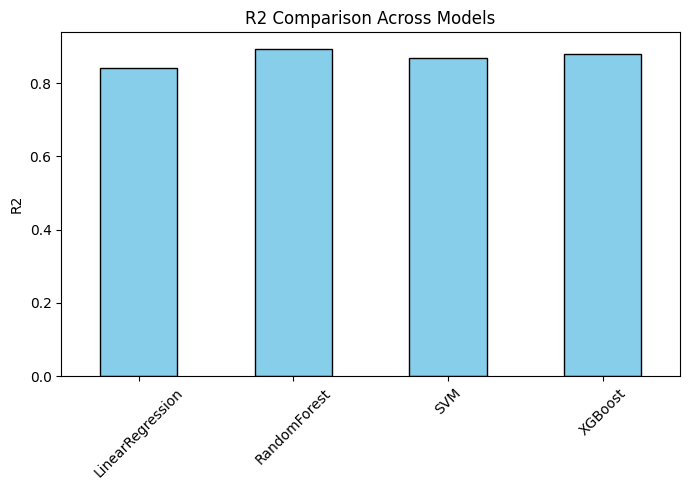

In [20]:
# Plot each metric separately
for metric in metrics_df.index:
    plt.figure(figsize=(7,5))
    metrics_df.loc[metric].plot(kind="bar", color="skyblue", edgecolor="black")
    plt.title(f"{metric} Comparison Across Models")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"metric_{metric}.png", dpi=300)
    plt.show()


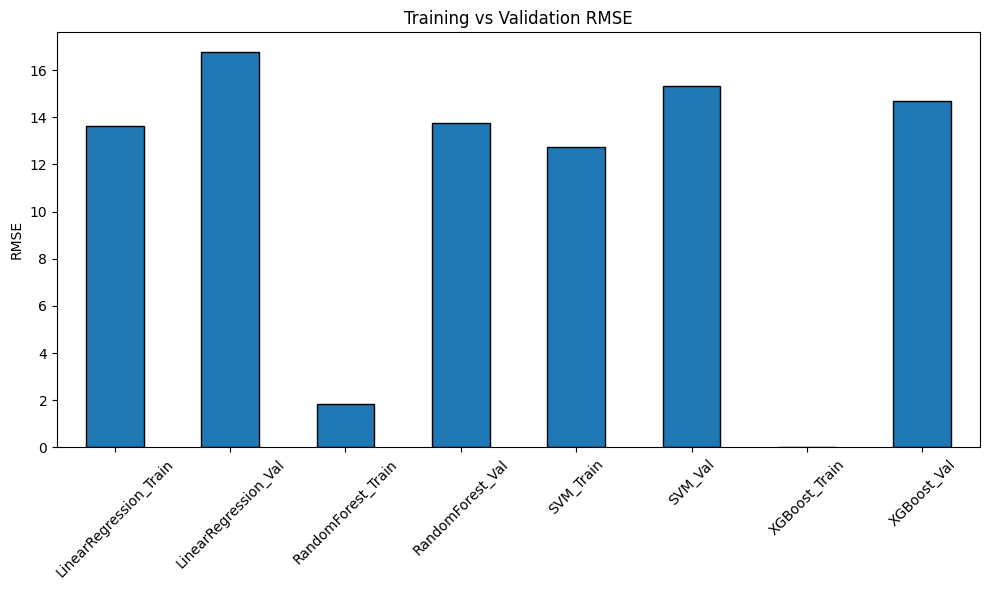

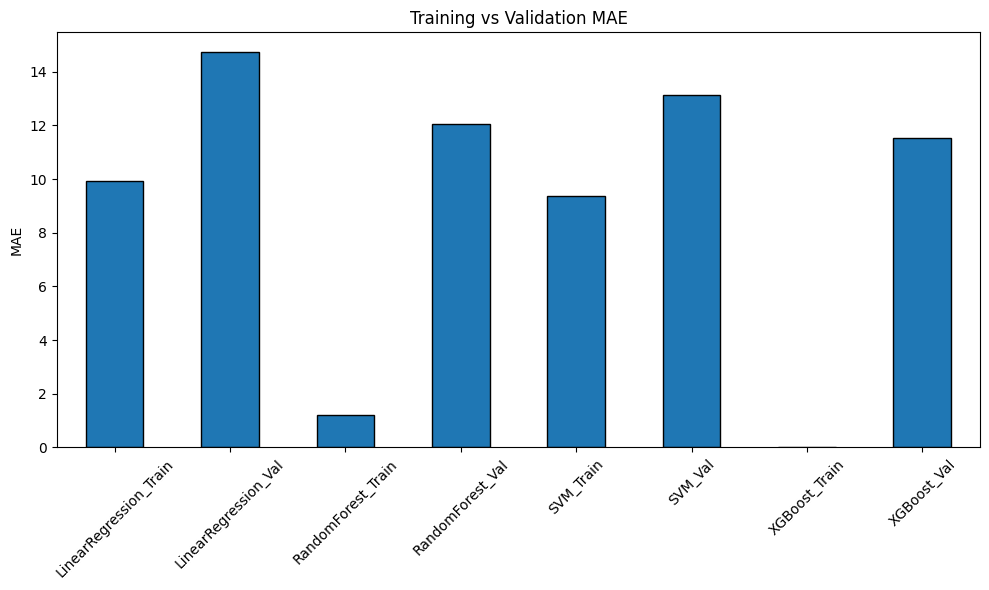

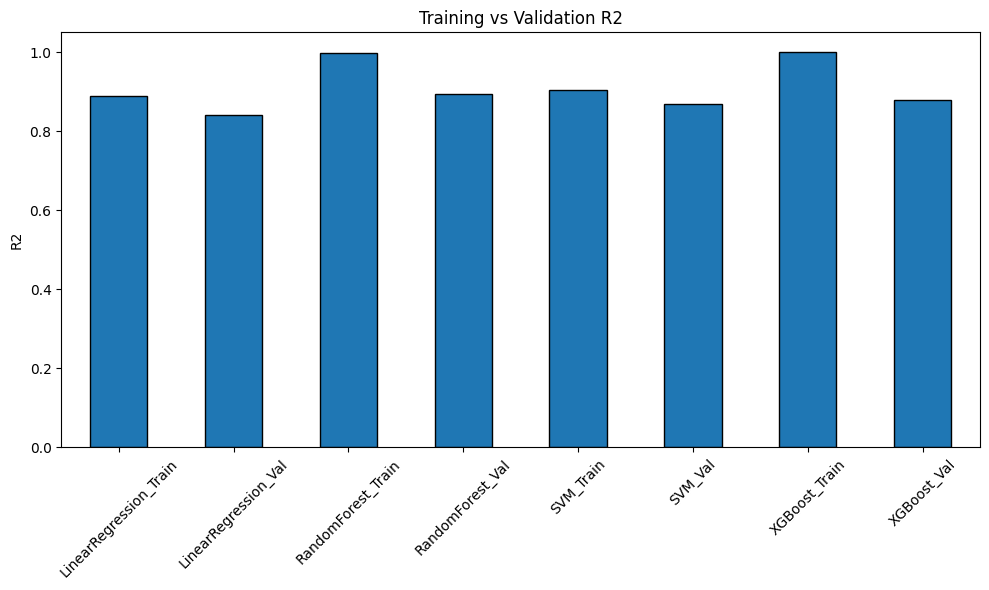

In [21]:
for metric in ["RMSE", "MAE", "R2"]:
    plt.figure(figsize=(10,6))
    comparison_df.loc[metric].plot(kind="bar", edgecolor="black")
    plt.title(f"Training vs Validation {metric}")
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"train_val_{metric}.png", dpi=300)
    plt.show()
